# Topic Modeling: Latent Dirichlet Allocation (LDA) vs. BERTopic

#### Kate Stadelman

Topic modeling is a Natural Language Processing (NLP) technique for discovering topics in a collection of documents, allowing you to see hidden structure in your text data. **Latent Dirichlet Allocation** (LDA), which was first presented in 2003 by David Blei, Andrew Ng and Michael I. Jordan, long reigned as the premier topic modeling method. However, **BERTopic** by Maarten Grootendorst burst on the scene in 2022, leveraging recent advancements in large language models. In this sample project, we will focus less on the mathematics behind these methods and more on practical differences between LDA and BERTopic and the basics of how to make topic models.


## Overview

| **LDA** | **BERTopic** |
| ----------------------------------------------- | ----------------------------------------------- |
| Bayesian probabilistic model that estimates probability distributions for topics in documents and words in topics. | Algorithm that leverages the transformer-based model BERT and c-TF-IDF to "create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions." (Grootendorst, 2022) |
| Each document is assigned topic probabilities.<br /> - Document 1 is 80% Topic 3, 15% Topic 2, 5% Topic 5 | Each document is assigned to a single topic.<br /> - Document 1 is Topic 3 |
| While extracted topics can be used to train classification models, topic generation is unsupervised. | Topic generation is unsupervised by default, but semi-supervised and supervised learning approaches are supported. |
| All documents are assigned to at least one topic. | Outlier documents are assigned to Topic -1 (no real topic). |
| No simple mechanism to merge topics. | Overlapping topics can be easily merged. |
| Coherence and perplexity measures readily available for topic evaluation. In practice, these measures may be less effective than using visualizations. | While you can maneuver Gensim (LDA) to calculate coherence and perplexity scores on BERTopic topics, BERTopic does not have these built-in for topic evaluation. However, there are many excellent visualizations available. |

In [Topic Models: Past, Present, Future](https://gradientflow.com/topic-models-past-present-future/), David Blei, co-creator of LDA, discusses how topic modeling allows you to "zoom in and zoom out" on your text data. You can tune your topic model to find a few major themes or many refined categories. In practice, we have found that tuning topic models is more of an art than a science. Visualizations are often much more effective than coherence and perplexity measures at finding the "best" model.

Because the intention of this article is to provide an overview of topic modeling methods, we leave the nuances of fine-tuning models for future articles. Just know that the tuning process is not necessarily straightforward and depends on what you are trying to accomplish.

## Vocabulary

Before creating our models, we review a few key NLP concepts:

- **Tokenization**: In NLP, tokenization is the task of breaking up documents into smaller chunks of text for processing. "Sentence Tokenization" splits documents into sentences, while "Word Tokenization" splits documents into words. There are a myriad of tokenizers available for use. The NLTK library even has a specialized TweetTokenizer designed for the emojis and hashtags found in tweets.

- **Stemming**: Stemming is an NLP technique for transforming words to their root form by chopping off suffixes like "-ing", "-es", and "-ed" (e.g. plays, played, playing -> play).

- **Lemmatization**: Lemmatization is an NLP technique for transforming words to their root form using a dictionary (e.g. is, are, was -> be). Stemming is more performant than lemmitzation, but lemmatization is more accurate.

- **Stop Words**: Stop words are commonly used words in a language (e.g. "a", "an", "the" in English) that occur frequently without contributing much to meaning. Stop words have historically been ignored or removed for many NLP tasks, including search engine queries and in the data preperation step for LDA topic modeling. While LLMs do not require stop word removal prior to generating embeddings, BERTopic still removes stop words when creating topic representations.

- **TF-IDF**: Both LDA and BERTopic topic modeling use a form of TF-IDF (term frequency-inverse document frequency). While we will not delve into the math here, know that TF-IDF measures the importance of a word to a document in a collection of documents. Suppose we have a collection of financial news articles. If we counted up all the words in each article, perhaps we find that one article mentions the word "stock" 10 times and "earnings" 5 times, while another article mentions "stock" 8 times and "t"ech" 5 times. Even though "stock" is the most frequent term in both articles, it provides less information about comparing the subject of each than "earnings" and "tech."

## Setup

This project is tested with `Python 3.12`.

Create a Python virtual environment for the project using the [virtualenv](https://pypi.org/project/virtualenv/) library, activate it, and install requirements.

```bash
python3.12 -m venv .venv
source .venv/bin/activate
pip install --upgrade pip
pip install -r requirements.txt
python3.12 -m spacy download en_core_web_md
```

## Exploratory Data Analysis

For our topic models, we are using the [Starbucks Reviews Dataset](https://www.kaggle.com/datasets/harshalhonde/starbucks-reviews-dataset/data), curated by Harshal H. 

Let's start by importing our data into a dataframe and inspecting the first few rows. There are 850 reviews, and six fields: name, location, date, rating, review, and image links. We only need rating and review for our purposes.

In [1]:
import json
import pandas as pd
import numpy as np
import random
import re

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

In [2]:
# Import data and display first few rows.
data = pd.read_csv('starbucks_reviews.csv')
print('Starbucks Reviews Dataset Size:', data.shape)
data.head()

Starbucks Reviews Dataset Size: (850, 6)


,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [3]:
# Notice that the above review text is truncated. 
# If you want to see full reviews, you can use the `display.max_colwidth` option.
pd.set_option('display.max_colwidth', None)
data['Review'].sample(10)

247                                                                                                                                                                                               I am VERY upset with my experience today. I ordered a Americana at the drive through at a very slow time. I paid lady with app and then she disappeared, I waited extra long and then a man came and handed me my drink after someone else was behind me on the drive through. When I picked up my drink for first time while driving the lid popped off and the coffee spilled on my hand burning it, my lap, my envelope I was mailing with a check, my car and car seat. I am lucky I did not get into an accident. I called store and spoke with manager to tell her what happened. I am very offended by her response, she said sorry and explained how it could not possibly be their fault because they triple check the lid. OBVIOUSLY they did not and I should not have had to argue with her. 
647                         

In [4]:
# Inspect all the columns, their types, and how many rows are nulls. No reviews are nulls, which is a little suspicious.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [5]:
# Let's see if any of the reviews are redundant (or if there is a default "null" review).
data.groupby(['Review'])['Review'].agg(['count']).sort_values(by='count', ascending=False)

,count
Review,
No Review Text,37
I then decided to call and ask her for her manager's #. She hung up on me 6 times after that and would not give me any #'s or names of her superior. The last time she answered and stated that I was getting the employee I asked to speak with in trouble. I am a regular at starbucks but after this crap I will go It's A Grind. I purchase coffe drinks 5-7 times a week too!,1
"ONLINE STORE IS USELESS. You can only call Mon.-Fri. 8 a.m.-5 p.m -- terrible customer service. Takes 10 days before they ship the order. Now they are using lowest level of delivery, takes 7-10 days to arrive. They are continually out of stock on items. Emails are not answered promptly. When they do answer they tell you it will ship and then it doesn't.",1
"My sweetheart and I went into our neighborhood Starbucks to get a coffee. We were standing waiting to be served looked at the food on display and noticed there was flies landing on the food and flying around. We pulled an employee aside and gestured towards the food and he said, ""Yes we are aware and it’s just a display we are not serving any of that to the public."" We were satisfied with that response and not more than 30 seconds go by and we witness a barista taking food out of the fly infested case put in oven to warm up for the public.",1
"My wife and I were at the Starbucks location at Bay St. and Cumberland here in Toronto. We are loyal customers, but this particular day, Saturday, April 14, 20012, was not very pleasant. I was pick-pocketed. My wallet was gone. I know it’s not your fault, but it’s easy target where your seats are at one point being very narrow. Hoards of people collect at one time and that’s where it happened. We truly enjoy your espressos and cappuccinos. Unfortunately, because of this incident, we will not be returning to this location and we will be informing our friends to be vigilant when going there. This was very unfortunate.",1
...,...
"I like the rewards program and the variety of drinks and specials. They have a good attitude, always ready to serve and make the drink the way you want it.",1
I like the way the set up is in the store and also the ambiance. The staff are nice and courteous. I like the different drinks and food items that are healthy choices.,1
"I like your product, particularly your coffee but notice that your cups, more often than not, tend to leak at the seam when the lid is in place. I have plenty of ruined shirts and a big dry cleaning bill to prove it.",1


In [6]:
# Remove rows that have a review of "No Review Text".
data = data[ data.Review != 'No Review Text' ].copy()
print('Starbucks Reviews w/Text Dataset Size:', data.shape)

Starbucks Reviews w/Text Dataset Size: (813, 6)


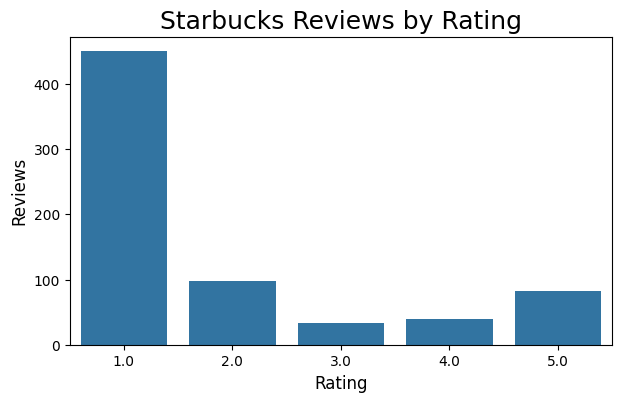

In [7]:
# Simple barchart to see count of reviews by rating.
plt.figure(figsize=(7,4))
sns.countplot(data=data, x='Rating')
plt.title('Starbucks Reviews by Rating', fontsize=18)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Reviews', fontsize=12)
plt.show()

Interestingly, our reviews are overwhelmingly negative. We will create LDA and BERTopic topic models for reviews with 1 or 2 star ratings to see if we can find out why customers are unsatisfied. Our final dataset has 548 reviews.

In [8]:
# Because reviews are so heavily negative, let's model 1-2 star reviews and see what's up.
df = data[ data.Rating <= 2 ].copy()
print('Starbucks Negative Reviews Dataset Size:', df.shape)

Starbucks Negative Reviews Dataset Size: (548, 6)


## Latent Dirichlet Allocation (LDA)

### LDA Topic Modeling Process Overview

1. Tokenize documents
2. Lemmatize tokens
3. Remove stop words
4. Create dictionary and bag-of-words corpus
5. Pass lemmas, dictionary and corpus into the LDA model with desired parameters

### LDA Data Preparation

In this section, we will be building out our stop words, as well as tokenizing and lemmatizing our review text. These steps are required for LDA topic modeling. However, for BERTopic, we do not lemmatize our text or remove stop words prior to feeding into the Hugging Face Sentence Transformer model. Stop words are still useful for BERTopic after clustering of our embeddings during the construction of our topic representations, so we will ultimately use the same stop word list for both models, but just at different points in the process.

In [9]:
# You only need to run this once to download the stopwords.
# import nltk
# nltk.download('stopwords')

In [10]:
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS as gensimSTOPWORDS
import spacy

In [11]:
# Generate our stop word list.
stop_words = set(stopwords.words('english'))
stop_words.update(gensimSTOPWORDS)
stop_words.update(['starbuck','starbucks','coffee','drink'])
stop_words = list(stop_words)

print(stop_words[:10])

['almost', 'made', 'con', 'd', 'coffee', 'alone', 'mightn', 'used', 'here', "isn't"]


In [12]:
# Load our lemmatizer.
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [13]:
# Tokens: There are a lot of great tokenizers out there, but here we make a simple one.
docs = df.Review.to_list()
tokens = []

for doc in docs:
    doc = str(doc).lower()
    chars = "`*{}[]()<>#+=;,.:!$?"  # remove punctuation
    for c in chars:
        if c in doc:
            doc = doc.replace(c, ' ')
    doc = re.sub('\"','',doc)  # remove double quotes
    doc = re.sub('-','_',doc)  # remove hypens
    doc = doc.replace('/n',' ')  # remove carriage returns
    doc = re.sub('\\s+',' ',doc)  # remove extra spaces
    
    # LDA performs much better with lemmitization than stemming.
    doc = [ word for word in nlp(doc) if len(word) > 1 ]
    doc = [ token.lemma_ for token in doc ]
    doc = [ word.lower() for word in doc if word.lower() not in stop_words and word.isalpha() ]
    tokens.append(doc)

df['doc'] = docs          ## For BERTopic
df['tokens'] = tokens     ## For LDA
df['token_count'] = [ len(doc) for doc in tokens ]

In [14]:
# Check out our new lemmatized reviews.
df.head(5)

,name,location,Date,Rating,Review,Image_Links,doc,tokens,token_count
5,Alyssa,"Sunnyvale, TX","Reviewed Sept. 14, 2023",1.0,We had to correct them on our order 3 times. They never got it right then the manager came over to us and said we made her employee uncomfortable because we were trying to correct our order. The manager tried was racist against my stepmom (Chinese) taking over her but when I (**) would talk she would stop talking and listen to me.,['No Images'],We had to correct them on our order 3 times. They never got it right then the manager came over to us and said we made her employee uncomfortable because we were trying to correct our order. The manager tried was racist against my stepmom (Chinese) taking over her but when I (**) would talk she would stop talking and listen to me.,"[correct, order, time, right, manager, come, employee, uncomfortable, try, correct, order, manager, try, racist, stepmom, chinese, talk, stop, talk, listen]",20
6,ken,"Spring Hill, FL","Reviewed Sept. 8, 2023",1.0,"I have tried Starbucks several different times in different locations just in case it was just the one store. But it's not. If you like coffee that taste like dirt scooped off the ground at a garbage dump, then this is the place for you.",['No Images'],"I have tried Starbucks several different times in different locations just in case it was just the one store. But it's not. If you like coffee that taste like dirt scooped off the ground at a garbage dump, then this is the place for you.","[try, different, time, different, location, case, store, like, taste, like, dirt, scoop, ground, garbage, dump, place]",16
7,Nikki,"Asheville, NC","Reviewed Aug. 25, 2023",1.0,"Starbucks near me just launched new fall foods and beverages yesterday. By noon yesterday they were out of all new items. The fall launch is huge and many people look forward to it all year. Maybe if you don’t have enough product to last even a couple of days, push back the launch until you do? I was so happy to get the email that it had come out that I left work on my break to brighten my day and so very disappointed to get there at 12:30pm and find out that it was all gone. Please Starbucks, do better.",['No Images'],"Starbucks near me just launched new fall foods and beverages yesterday. By noon yesterday they were out of all new items. The fall launch is huge and many people look forward to it all year. Maybe if you don’t have enough product to last even a couple of days, push back the launch until you do? I was so happy to get the email that it had come out that I left work on my break to brighten my day and so very disappointed to get there at 12:30pm and find out that it was all gone. Please Starbucks, do better.","[near, launch, new, fall, food, beverage, yesterday, noon, yesterday, new, item, fall, launch, huge, people, look, forward, year, maybe, product, couple, day, push, launch, happy, email, come, leave, work, break, brighten, day, disappointed]",33
8,Alex,"Reisterstown, MD","Reviewed Aug. 5, 2023",1.0,"I ordered online for the Reisterstown Rd, St Thomas SC 99000 and they gave me the wrong drink size so ordered a venti they gave me a grande. Just a bit upset that I paid over 5 bucks for a drink and got the wrong thing.",['No Images'],"I ordered online for the Reisterstown Rd, St Thomas SC 99000 and they gave me the wrong drink size so ordered a venti they gave me a grande. Just a bit upset that I paid over 5 bucks for a drink and got the wrong thing.","[order, online, reisterstown, rd, st, thomas, sc, wrong, size, order, venti, grande, bit, upset, pay, buck, wrong, thing]",18
9,Sunny,"Zionville, Other","Reviewed Aug. 4, 2023",1.0,"Staff at the Smythe St. Superstore location in Fredericton, NB often seen tired but today, a woman named Senoa (Senora?) was morose, glum, uncommunicative (even after I tried to engage her to sympathize, as there was obviously a bad mood happening), scruffy looking, almost rude. And, the Americano I ordered tastes watery. I go t

In [15]:
# It is always good to do a detailed review to see how our text was transformed.
i = random.randint(0,len(docs))
print(docs[i])
print(tokens[i])

Starbucks response to my complaints was dog **. I have my whole company get the new spicy sandwich and it tasted like dog ** and we couldn't even eat it and threw out them and all they said was "sorry we will tell the right people." I've only ever complained about a company four times in my life and this is the only time I felt like I was told to go ** myself.
['response', 'complaint', 'dog', 'company', 'new', 'spicy', 'sandwich', 'taste', 'like', 'dog', 'eat', 'throw', 'sorry', 'tell', 'right', 'people', 'complain', 'company', 'time', 'life', 'time', 'feel', 'like', 'tell']


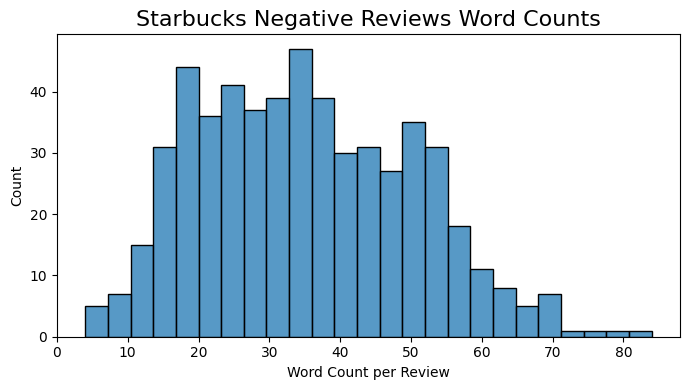

In [16]:
# Check review token count distribution.
fig = plt.figure(figsize=(7,4))
sns.histplot(x='token_count', data=df, bins=25)
plt.title('Starbucks Negative Reviews Word Counts', fontsize=16)
plt.xlabel('Word Count per Review')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

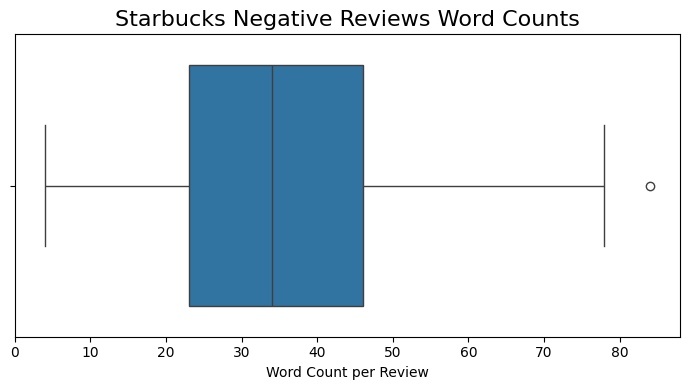

In [17]:
# Another view of token count distribution.
fig = plt.figure(figsize=(7,4))
sns.boxplot(x='token_count', data=df)
plt.title('Starbucks Negative Reviews Word Counts', fontsize=16)
plt.xlabel('Word Count per Review')
plt.tight_layout()
plt.show()

In [18]:
# Remove reviews that have fewer than 10 and more than 70 tokens.
df.drop(df[(df.token_count < 10) | (df.token_count > 70)].index, inplace=True)
print('Final Review Dataset:', data.shape)

Final Review Dataset: (813, 6)


###  LDA Tuning

Feel free to play around with this tuning code. Generally, we look for higher coherence and lower perplexity. Interestingly, the best coherence and perplexity scores do not always lead to the best model. Compare files lda_pyLDAvis_tuned.html (best scored model) vs. lda_pyLDAvis.html (final). Some elements of topic models are still more art than science.

**Parameters**

* num_topics: The number of topics/clusters.
* alpha: A-priori belief on document-topic distribution
* beta (eta): A-priori belief on topic-word distribution

**Measures**

In his article, [Evaluate Topic Models: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0), Shashank Kapadia provides excellent descriptions of common LDA topic modeling measures.

* Coherence: "Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic." 
* Perplexity: "Perplexity [...] is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set."

In [19]:
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [20]:
# Create dictionary and corpus.
texts = df.tokens.to_list()
id2word = corpora.Dictionary(texts)
corpus = [ id2word.doc2bow(doc) for doc in texts ]

In [21]:
# LDA Tuning based on coherence and perplexity.
ks = [ 5, 10, 15, 20 ]
alphas = ['asymmetric']
betas = ['symmetric',0.1,1,10,25]
results = []

for k in ks:
    for alpha in alphas:
        for beta in betas:
            lda_model = models.ldamodel.LdaModel(
                                            corpus=corpus,
                                            id2word=id2word,
                                            num_topics=k, 
                                            random_state=38,
                                            passes=10,
                                            alpha=alpha,
                                            eta=beta,
                                            per_word_topics=True
            ) 
            lda_coherence = models.CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, texts=texts, coherence='c_v').get_coherence()
            lda_perplexity = lda_model.log_perplexity(corpus)
            results.append([k, alpha, beta, lda_coherence, lda_perplexity])

lda_tuning = pd.DataFrame(results, columns=['k','alpha','beta','coherence','perplexity'])
lda_tuning.to_csv('lda/lda_tuning.csv', index=False)

In [22]:
# "Best" model from tuning.
lda_model = models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=id2word,
                num_topics=20,
                random_state=38,
                passes=10,
                alpha='asymmetric',
                eta = 10,
                per_word_topics=True
)

# We will compare this to our final LDA Topic model using default alpha and beta parameters.
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.save_html(LDAvis_prepared, f'lda/lda_pyLDAvis_tuned.html')

### LDA Model

In [23]:
# Final LDA Topic model using default alpha and beta parameters.
lda_model = models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=id2word,
                num_topics=15,
                random_state=38,
                passes=10,
                alpha='auto',
                per_word_topics=True
)
lda_model.save('lda/lda.model') 

In [24]:
# This is how you would load a previously saved model.
lda_model = models.ldamodel.LdaModel.load('lda/lda.model')

In [25]:
# Compute coherence and perplexity scores for our final model.
lda_coherence = models.CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, texts=texts, coherence='c_v').get_coherence()
lda_perplexity = lda_model.log_perplexity(corpus)

print('LDA Coherence:', lda_coherence)
print('LDA Perplexity:', lda_perplexity)

LDA Coherence: 0.32449838200441466
LDA Perplexity: -7.599706084575392


In [26]:
# pyLDAvis is probably the best way to evaluate an LDA topic model.
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.save_html(LDAvis_prepared, f'lda/lda_pyLDAvis.html')

In [27]:
# Print topics to see which words are contributing to each topic.
lda_model.print_topics(num_topics=-1)

[(0,
  '0.038*"card" + 0.018*"order" + 0.013*"tell" + 0.012*"receive" + 0.012*"customer" + 0.011*"use" + 0.011*"money" + 0.011*"gift" + 0.009*"send" + 0.008*"service"'),
 (1,
  '0.012*"store" + 0.012*"card" + 0.011*"manager" + 0.011*"service" + 0.011*"people" + 0.011*"year" + 0.010*"open" + 0.008*"pay" + 0.008*"customer" + 0.008*"order"'),
 (2,
  '0.020*"ask" + 0.012*"like" + 0.012*"customer" + 0.012*"service" + 0.011*"cup" + 0.011*"day" + 0.011*"order" + 0.011*"bad" + 0.011*"tea" + 0.010*"charge"'),
 (3,
  '0.013*"customer" + 0.012*"employee" + 0.011*"store" + 0.010*"like" + 0.010*"time" + 0.009*"tell" + 0.009*"morning" + 0.007*"latte" + 0.007*"refill" + 0.006*"manager"'),
 (4,
  '0.015*"store" + 0.012*"order" + 0.009*"tell" + 0.009*"time" + 0.009*"buy" + 0.008*"customer" + 0.007*"ask" + 0.006*"purchase" + 0.006*"spend" + 0.006*"card"'),
 (5,
  '0.021*"customer" + 0.013*"store" + 0.012*"ask" + 0.010*"tell" + 0.009*"card" + 0.008*"like" + 0.006*"balance" + 0.006*"wait" + 0.006*"employe

In [28]:
# Add the highest probability LDA topic for each Starbucks review to the dataframe.
def get_lda_topics(tokens):
       corpus = id2word.doc2bow(tokens)
       topics = lda_model.get_document_topics(corpus, minimum_probability=0.1)
       topics_sorted = list(sorted(topics, key=lambda tup: tup[1], reverse=True))
       return topics_sorted, topics_sorted[0][0], topics_sorted[0][1]

df['lda_topics_all'] = df.tokens.apply(lambda x: get_lda_topics(x))
df['lda_topics'] = df['lda_topics_all'].apply(lambda x: x[0])
df['lda_primary_topic'] = df['lda_topics_all'].apply(lambda x: x[1])
df['lda_primary_topic_probability'] = df['lda_topics_all'].apply(lambda x: x[2])
df.drop(columns=['lda_topics_all'],inplace=True)

In [29]:
# Print sample of LDA topics.
df[['Review','lda_topics','lda_primary_topic','lda_primary_topic_probability']].sample(5)

,Review,lda_topics,lda_primary_topic,lda_primary_topic_probability
150,"There is no social responsibility at Starbucks. Starbucks is one of the most polluting stores in our City. There is no recycling whatsoever. Hundreds of plastic cups are tossed into trash each day at just one location, and thousands of them with all the locations in our City. When I asked the manager for the recycle bin, he shrugged his shoulders and said, ""I don't know how to get one."" I walked out and saw a recycle bin that was being used as a trash can. I contacted Starbucks' website and gave my feedback, but nothing was changed at the local stores. For a company who pretends to be all about community, they are destroying our planet faster than most of other stores.","[(3, 0.81684583), (2, 0.17197233)]",3,0.816846
414,"I typically order only one thing - iced caramel macchiato. This is one of the simplest drinks they can make. Ice, vanilla syrup, milk, espresso, caramel drizzle on top. Simple, right? Well, apparently not. I have ordered this drink and been kicked with a bitterness because they DON'T ADD THE SYRUP! I would put this down to someone poorly trained at one location, but it has happened at three in my area.","[(8, 0.6897828), (11, 0.29381528)]",8,0.689783
675,"I visit a lot of Starbucks. I like the atmosphere, and the people are really nice to me. That was until I went to the Starbucks on 749 Lincoln Road, Miami Beach, FL. I went in at around 7:30 AM, and it wasn't very busy. I was the only person in line. The male barista greeted me, and I asked for a tall cup of hot water, because I had a VIA (that I actually bought from that Starbucks, two days prior). He said sure, and he went over to pour the hot water and said (in a very snappy tone) ""I'll give you a small cup"". At first I thought she was offering me a small cup, because that's the size that's recommended with a VIA. So I said, ""oh no, can you please give me a tall one, because it's too strong in a small cup"".","[(7, 0.7276692), (4, 0.2624792)]",7,0.727669
7,"Starbucks near me just launched new fall foods and beverages yesterday. By noon yesterday they were out of all new items. The fall launch is huge and many people look forward to it all year. Maybe if you don’t have enough product to last even a couple of days, push back the launch until you do? I was so happy to get the email that it had come out that I left work on my break to brighten my day and so very disappointed to get there at 12:30pm and find out that it was all gone. Please Starbucks, do better.","[(14, 0.9850686)]",14,0.985069
24,During Covid their restrictions were over the top and still require staff to put cream and sugar in my coffee. Starbucks this is nonsense - no wonder you have 3 stars. Why should your customers wait for a cup of coffee as if I had ordered a frap. Dumb policy. Sell coffee not politics.,"[(13, 0.45045573), (7, 0.36148694), (5, 0.16550484)]",13,0.450456


In [30]:
# Print sample of specific LDA topics.
df[['Review','lda_primary_topic','lda_primary_topic_probability']].loc[df['lda_primary_topic'] == 5].sample(5)

,Review,lda_primary_topic,lda_primary_topic_probability
611,I do not know why Kraft would want to distribute Starbucks Coffee. It is the worst coffee I have ever tasted and they have no idea how to make a good coffee. Come to Australia to see how it is done.,5,0.952595
465,"I have come into this Starbucks location about a half dozen times. I do not go to it anymore. It is by far, the dirtiest and most unfriendliest location I have ever been to. Many times, I had to go grab some napkins and clean up a table that had coffee or whatever all over it. Newspapers are left all over the place, many of them at least a week old, and shoved into cushions, in corners, on the creamer/milk counter, etc. The cream/milk/sugar counter is always (as in always) covered with wet, sugary, spilled milk, and the trash receptacle is filled to overflowing.",5,0.987040
125,"Radio too loud. Could not hear person behind counter after waiting 5 mins to be helped. Not patient with me. Surprised I asked for a straw. That saying ""be kind as you do not know what the person you are talking to may be dealing with"". Not asked what flavor of coffee I would like to order. Maybe if the music was not so loud... We each would have understood each other better.",5,0.981180
118,"I have family members who are police officers so...yeah there's that. You don't have any sugar free options in fraps, and your paper straws get soggy in seconds. I'm done overpaying just to sip through soggy paper straws. Starbucks treatment of police officers, their sugar free options, and their straws SUCK!",5,0.981180
153,"We are at MCO Orlando airport by gates 1-9. I waited 30 minutes in line to find out there was no bold blend. The girl behind the counter asked me if I wanted to wait 7-10 mins for them to brew a pot. I told her no, that I’d already waited 30. (There were 6 employees behind the counter but I think only two working - in fact I walked up to the second register when a customer left and the girl there told me she wasn’t open). So I finally got my two pikes ventis - had to charge thru my Starbucks Acct because I wasn’t going to wait in that line again and not enough cash for two coffees..",5,0.987680


## BERTopic

### BERTopic Tuning

Per [BERTopic documentation](https://maartengr.github.io/BERTopic/algorithm/algorithm.html), BERTopic can be viewed as a sequence of steps to create its topic representations.

1. Embeddings (Hugging Face SentenceTransformer)
2. Dimensionality Reduction (UMAP)
3. Clustering (HDBSCAN)
4. Tokenizer (CountVectorizer)
5. Weighting Scheme (c-TF-IDF)
6. Fine-Tune Representations (Optional Fine Tuning)

In this section, we explore tuning methods for Dimensionality Reduction (UMAP) and Clustering (HDBSCAN).

In [31]:
# Ignore user and deprication warnings from UMAP and BERTopic.
import warnings
warnings.filterwarnings('ignore')

from bertopic import BERTopic
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [32]:
# A few variables for the BERTopic tuning process.
model_name = 'bertopic'
docs = df.doc.to_list()

# James Briggs (https://www.pinecone.io/learn/bertopic/) has a brilliant visualization for BERTopic
# that we will be using. To enhance this visualization, we will be adding the actual review text.
reviews = df.Review.str.wrap(100).copy()
reviews = [ review.replace('\n', '<br>') for review in reviews ] 

In [33]:
# In order to tune UMAP and HDBSCAN, we must compute embeddings.
n = len(docs)
batch_size = 10

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = np.zeros((n, embedding_model.get_sentence_embedding_dimension()))

for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = docs[i:i_end]
    batch_embed = embedding_model.encode(batch, normalize_embeddings=True)
    embeddings[i:i_end,:] = batch_embed

100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


#### UMAP Parameters

Please see [Basic UMAP Parameters](https://umap-learn.readthedocs.io/en/latest/parameters.html) for more information.

* **n_components**: "As is standard for many scikit-learn dimension reduction algorithms UMAP provides a n_components parameter option that allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into."
* **n_neighbors**: This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of n_neighbors will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader of the data.
* **min_dist**: "The min_dist parameter controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation."
* **metric**: The metric parameter "controls how distance is computed in the ambient space of the input data."

In [34]:
# Please check out the graphs in bertopic/tuning graphs. It takes time to develop an intuition around
# how each of these parameters affects the resulting reduced embeddings.
n_components = 25
nns = [  2, 5, 10 ]
mds = [ 0.1, 0.5, 0.99 ]
metrics = [ 'euclidean', 'cosine' ]

for n_neighbors in nns:
    for min_dist in mds:
        for metric in metrics:
            umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
            reduced_embeddings = umap_model.fit_transform(embeddings)

            fig = px.scatter_3d(
                x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], z=reduced_embeddings[:,2],
                hover_data={"review":reviews},
            )
            fig.update_traces(
                hovertemplate="<br>".join([
                    "Review: %{customdata[0]}",
                ])
            )

            fig.write_html(f'{model_name}/tuning_graphs/umap-topics-3d-parameter-tuning-{metric}-{n_neighbors}-{min_dist}.html')

In [35]:
# In order to tune HDBSCAN, must finalize our parameter selection for UMAP.
n_components = 25
n_neighbors = 5
min_dist = 0.5
metric = 'cosine'

fit = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=38)
reduced_embeddings = fit.fit_transform(embeddings)

#### HDBSCAN Parameters

Please see [Parameter Selection for HDBSCAN](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html) for more information.

* **min_cluster_size**: "The primary parameter to effect the resulting clustering is min_cluster_size. Ideally this is a relatively intuitive parameter to select – set it to the smallest size grouping that you wish to consider a cluster."
* **min_samples**: "The simplest intuition for what min_samples does is provide a measure of how conservative you want you clustering to be. The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas."

In [36]:
# Check out the default parameters for HDBSCAN.
clusterer = hdbscan.HDBSCAN()
clusterer.fit(reduced_embeddings)
clusterer.get_params()

{'algorithm': 'best',
 'allow_single_cluster': False,
 'alpha': 1.0,
 'approx_min_span_tree': True,
 'branch_detection_data': False,
 'cluster_selection_epsilon': 0.0,
 'cluster_selection_epsilon_max': inf,
 'cluster_selection_method': 'eom',
 'core_dist_n_jobs': 4,
 'gen_min_span_tree': False,
 'leaf_size': 40,
 'match_reference_implementation': False,
 'max_cluster_size': 0,
 'memory': Memory(location=None),
 'metric': 'euclidean',
 'min_cluster_size': 5,
 'min_samples': None,
 'p': None,
 'prediction_data': False}

HDBSCAN is similar to DBSCAN in that it has a -1 cluster for "outlier" / unclustered items. Tuning BERTopic involves the interplay between how many topics (clusters) are made vs. how many documents end up without a topic (unclustered). Generally, topics and outliers are inversely related (more topics = less outliers; less topics = more outliers).

In [37]:
print('Default HDBSCAN Number of Topics:', len(set(clusterer.labels_)))
print('Default HDBSCAN Number of Outliers:', (clusterer.labels_ == -1).sum())

Default HDBSCAN Number of Topics: 4
Default HDBSCAN Number of Outliers: 128


In [38]:
# Calculate the number of clusers vs. outliers for differet HDBSCAN parameters.
min_cls = [ 2, 3, 4, 5, 10, 15, 20]
min_smps = [None, 1, 2, 3, 4, 5]
outliers = []

for min_samples in tqdm(min_smps):
    for min_cluster_size in min_cls:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        clusterer.fit(reduced_embeddings)

        outliers.append((f'min_cluster_size={min_cluster_size}, min_samples={min_samples}', len(set(clusterer.labels_)), 
            (clusterer.labels_ == -1).sum(), (.05 * df.shape[0]), (.1 * df.shape[0]), (.2 * df.shape[0]), (.3 * df.shape[0])))

outliers = sorted(outliers, key=lambda x: x[2])
hdbscan_df = pd.DataFrame(outliers, columns = ['params', 'clusters', 'outliers', 'sample_05_pct','sample_10_pct','sample_20_pct',
    'sample_30_pct'])
hdbscan_df.head(30)

100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


,params,clusters,outliers,sample_05_pct,sample_10_pct,sample_20_pct,sample_30_pct
0,"min_cluster_size=4, min_samples=None",3,56,26.6,53.2,106.4,159.6
1,"min_cluster_size=2, min_samples=4",3,56,26.6,53.2,106.4,159.6
2,"min_cluster_size=3, min_samples=4",3,56,26.6,53.2,106.4,159.6
3,"min_cluster_size=4, min_samples=4",3,56,26.6,53.2,106.4,159.6
4,"min_cluster_size=5, min_samples=4",3,56,26.6,53.2,106.4,159.6
5,"min_cluster_size=10, min_samples=4",3,56,26.6,53.2,106.4,159.6
6,"min_cluster_size=15, min_samples=4",3,56,26.6,53.2,106.4,159.6
7,"min_cluster_size=20, min_samples=4",3,56,26.6,53.2,106.4,159.6
8,"min_cluster_size=2, min_samples=1",141,71,26.6,53.2,106.4,159.6
9,"min_cluster_size=3, min_samples=1",84,87,26.6,53.2,106.4,159.6


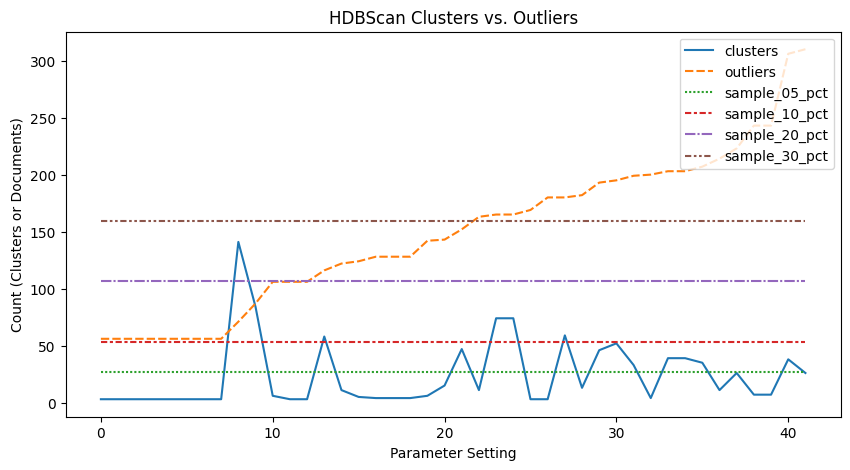

In [39]:
# Visulaization of HDBSCAN clusters vs. outliers, with additional markers for percent of sample size.
fig = plt.figure(figsize=(10,5))
sns.lineplot(data=hdbscan_df)
plt.legend(loc='upper right')
plt.title('HDBScan Clusters vs. Outliers')
plt.xlabel('Parameter Setting')
plt.ylabel('Count (Clusters or Documents)')
fig.savefig(f'{model_name}/tuning_graphs/hdbscan-cluster-outliers-{n_neighbors}-{min_dist}.png')
plt.show()

In [40]:
# Select final HDBSCAN parameters.
min_cluster_size = 15
min_samples = 1

clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
clusterer.fit(reduced_embeddings)

,min_cluster_size,15
,min_samples,1
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


Visualizing the number of documents in each cluster is helpful to identify two problems: 

1. a high outlier count (cluster -1); and
2. a "super" cluster that contains most of the documents (meaningless topic).

This example has about 30% outilers with pretty well-balanced topics.

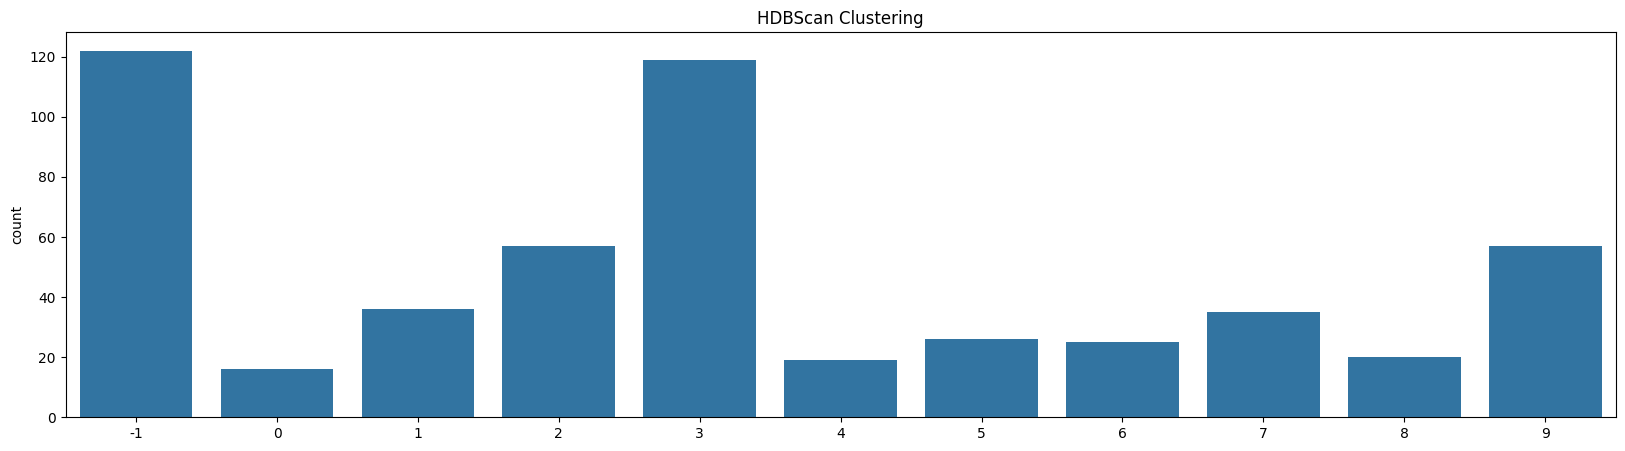

In [41]:
# Count of documents in each cluster. 
fig = plt.figure(figsize=(20,5))
sns.countplot(x=clusterer.labels_)
plt.title('HDBScan Clustering')
fig.savefig(f'{model_name}/tuning_graphs/hdbscan-cluster-counts-{n_neighbors}-{min_dist}-{min_cluster_size}-{min_samples}.png')
plt.show()

In [42]:
# A similar 3D visualization for the final BERTopic model is usually in alignment with results from our tuned UMAP and HDBCAN.
clusters = [str(x) for x in clusterer.labels_]
palette = sns.color_palette("hls",len(set(clusters))).as_hex()

fig = px.scatter_3d(
    x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], z=reduced_embeddings[:,2],
    color=clusters,
    hover_data={"review":reviews},
    color_discrete_sequence=palette
)

fig.write_html(f'{model_name}/tuning_graphs/hdbscan-topics-3d-{n_neighbors}-{min_dist}-{min_cluster_size}-{min_samples}.html')

### BERTopic Model

In [43]:
# Parameter settings for our final BERTopic model.
n_components = 25
n_neighbors = 5
min_dist = 0.5
metric = 'cosine'
min_cluster_size = 15
min_samples = 1

In [44]:
# Use our parameters to initialize our BERTopic components.
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=min_dist, metric=metric, random_state=38)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True, gen_min_span_tree=True)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)

In [45]:
# Create our final BERTopic Model.
docs = df.doc.to_list()

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=10,
    language='english',
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_params()

2025-07-03 14:14:56,140 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2025-07-03 14:15:38,245 - BERTopic - Embedding - Completed ✓
2025-07-03 14:15:38,246 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-03 14:15:39,112 - BERTopic - Dimensionality - Completed ✓
2025-07-03 14:15:39,113 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-03 14:15:39,214 - BERTopic - Cluster - Completed ✓
2025-07-03 14:15:39,217 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-03 14:15:39,330 - BERTopic - Representation - Completed ✓


{'calculate_probabilities': True,
 'ctfidf_model': ClassTfidfTransformer(),
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x15403ba70>,
 'hdbscan_model': HDBSCAN(gen_min_span_tree=True, min_cluster_size=15, min_samples=1,
         prediction_data=True),
 'language': None,
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': None,
 'representation_model': None,
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_components=25, n_jobs=1, n_neighbors=5, random_state=38, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 'vectorizer_model': CountVectorizer(ngram_range=(1, 2),
                 stop_words=['almost', 'made', 'con', 'd', 'coffee', 'alone',
                             'mightn', 'used', 'here', "isn't", 'well', 'ain',
                           

In [46]:
# Add topics and topic labels to our dataframe.
df['bertopic_topic'] = topic_model.topics_
df['bertopic_label'] = df['bertopic_topic'].apply(lambda x: topic_model.topic_labels_[x])

# More information on how to save our topic model can be found here: 
# https://maartengr.github.io/BERTopic/getting_started/serialization/serialization.html
topic_model.save(f'{model_name}/model')

2025-07-03 14:15:39,450 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [47]:
# Print sample of specific BERTopic topics.
df[['bertopic_label','doc']].loc[df['bertopic_topic'] == 1].head(5)

,bertopic_label,doc
5,1_manager_said_rude_went,We had to correct them on our order 3 times. They never got it right then the manager came over to us and said we made her employee uncomfortable because we were trying to correct our order. The manager tried was racist against my stepmom (Chinese) taking over her but when I (**) would talk she would stop talking and listen to me.
9,1_manager_said_rude_went,"Staff at the Smythe St. Superstore location in Fredericton, NB often seen tired but today, a woman named Senoa (Senora?) was morose, glum, uncommunicative (even after I tried to engage her to sympathize, as there was obviously a bad mood happening), scruffy looking, almost rude. And, the Americano I ordered tastes watery. I go to Starbucks for a treat after a long day. It a difficult experience, to ease stress and have a pleasant experience. I’m going to sell a different location after today’s grumpy girl."
40,1_manager_said_rude_went,"Yet another person with a Horrible Experience at a Starbucks... Specifically, the Starbucks at Johnson Creek Crossing in Portland, Oregon. I was trying to give my order at the drive-thru, but apparently the person who was taking it couldn't hear me very well. A short, decaf vanilla mocha non-fat no-whip. Still, she had every thing right but the vanilla, so when she asked me if it was right, I said ""Everything but the vanilla."" She said she was having trouble hearing me, so I said loudly ""Va-nil-la!"" She said she was still having trouble hearing me, and for some unknown reason changed the drink to a grande vanilla latte, so I said loudly ""Moch-a!"" and then asked her why she changed the drink/size? She said she more about not being able to hear me, so in a very loud voice I said ""SHORT... DECAF... VANILLA... MOCHA.. NONFAT... NO WHIP"" At which point she said I was treating her badly and refused to take my order."
52,1_manager_said_rude_went,"I frequent this particular Starbucks about 5 times a week. This is the Edgemont Branch location. My usual drink is grande in venti cup, extra milk. Most of the employees know my face and some know my name as I go there quite often. Today I went to get my usual drink. I know exactly how much coffee and how much milk goes into the cup. The coffee level is at the edge of the circle on the cup. So when I saw the amount of coffee was less than usual and had too much room, I pointed it to the employee. She then proceeded to go to the back to talk to someone else, then came back with a measured cup and said we can't do that and talked to me in a way that really ruined the experience for me as she was making a fuss over nothing."
79,1_manager_said_rude_went,"I came back to Oklahoma City due to a business meeting and to visit my family. While visiting a Starbucks location in Oklahoma City, OK at 200 S Oklahoma City, OK 73104, I was threatened verbally as well as physically by an employee. I am a long-time daily customer of Starbucks. I would say I visit a location at least 335 days out of 365 per year. On the morning of April 5th, 2022, I went in to purchase my usual daily cup of coffee. I decided to purchase a protein box and a cheese and fruit box as well. While waiting in a fairly long line I arrived at the counter in which I were greeted by a young lady named **. My order was placed for a venti sized blonde roast of brewed coffee, including eight packages of agave, sugar free vanilla, cream and the two boxes discussed above."


In [48]:
# Representative documents are extremely useful in getting a feel for the topics.
rep_docs = { str(k) : v for k,v in topic_model.representative_docs_.items()}

with open(f'{model_name}/representative_documents.json', 'w') as f:
    f.write(json.dumps(rep_docs, indent=4))

In [49]:
# BERTopic also has functionality for a similarirty search.
top_n = 3
search_topics, search_similarity = topic_model.find_topics('rewards program', top_n=top_n)
print('Relevant Topics with Similarity Scores:', [ (search_topics[i], search_similarity[i]) for i in range(top_n) ])

Relevant Topics with Similarity Scores: [(0, 0.33556098), (-1, 0.11964199), (4, 0.110547885)]


#### BERTopic Visualizations

In [50]:
# Topic Word Scores show the top words for each topic. Recall the similar output for our LDA topic model using print_topics.
fig = topic_model.visualize_barchart(top_n_topics=50, n_words=8, width=300)
fig.write_html(f'{model_name}/bertopic-topic-word-scores.html')
fig.show()

In [51]:
# The Similarity Matrix allows you to understand topic similarity. BERTopic does have functionality to combine topics if desired.
fig = topic_model.visualize_heatmap(custom_labels=True)
fig.write_html(f'{model_name}/bertopic-heatmap.html')
fig.show()

In [52]:
# Intertopic Distance Map is similar to pyLDAviz.
fig = topic_model.visualize_topics()
fig.write_html(f'{model_name}/bertopic-intertopic-distance.html')
fig.show()

In [53]:
# The Heirarchical Clustering visualiztion is another view of topic relationships.
fig = topic_model.visualize_hierarchy(custom_labels=True)
fig.write_html(f'{model_name}/bertopic-topic-hierarchy.html')
fig.show()

In [54]:
# This 2D representation of documents and topics is built into the BERTopic library. We will also make a 3D version.
fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)
fig.write_html(f'{model_name}/bertopic-topic-documents.html')
fig.show()

In [55]:
# Our custom 3D BERTopic visualization requires feeding in the reduced embeddings (UMAP).
reduced_embeddings = umap_model.fit_transform(embeddings)

clusters = df['bertopic_label']
palette = sns.color_palette("hls",len(set(clusters))).as_hex()
reviews = df.Review.str.wrap(100).copy()
reviews = [ review.replace('\n', '<br>') for review in reviews ] 

fig = px.scatter_3d(
    x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], z=reduced_embeddings[:,2],
    color=clusters,
    hover_data={"review": reviews},
    color_discrete_sequence=palette
)
# update the font if you want!
# fig.update_layout(
#     hoverlabel=dict(
#         font_size=16,
#         font_family="Rockwell"
#     )
# )

fig.write_html(f'{model_name}/bertopic-3d.html', full_html=False)
fig.show()

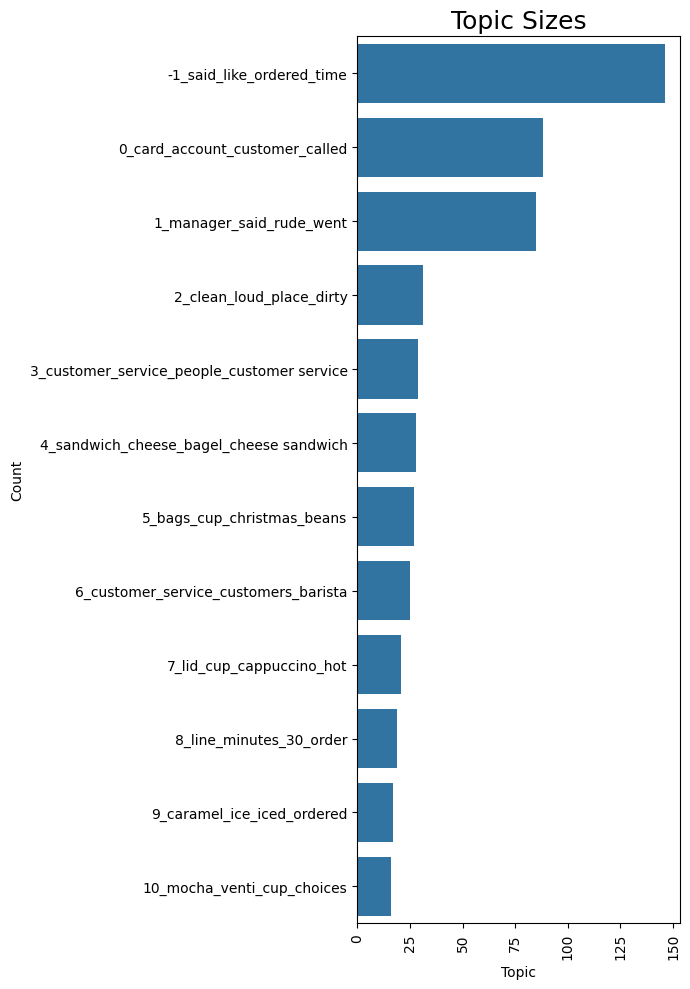

In [56]:
# Count of reviews by topic.
fig = plt.figure(figsize=(7,10))
sns.countplot(y='bertopic_label', data=df, order=df['bertopic_label'].value_counts().index)
plt.title('Topic Sizes', fontsize=18)
plt.xticks(rotation=90)
plt.xlabel('Topic')
plt.ylabel('Count')
plt.tight_layout()
fig.savefig(f'{model_name}/bertopic-topic-sizes.png')
plt.show()

## Further Reading & Resources

### LDA Topic Modeling
- [Topic Models: Past, Present, Future](https://gradientflow.com/topic-models-past-present-future/)
- [Gensim: Topic Modeling for Humans](https://radimrehurek.com/gensim/)
- [A Beginner’s Guide to Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)
- [Evaluate Topic Models: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

### BERTopic
- [BERTopic](https://maartengr.github.io/BERTopic/index.html)
- [Advanced Topic Modeling with BERTopic](https://www.pinecone.io/learn/bertopic/)
- [BERTopic Explained](https://www.youtube.com/watch?v=fb7LENb9eag)


## References 
- Harshal H. (2023, September). *Starbucks Reviews Dataset* ([Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)](https://creativecommons.org/licenses/by-nc/4.0/)) [Data set]. Kaggle. Retrieved October 22, 2023 from (https://www.kaggle.com/datasets/harshalhonde/starbucks-reviews-dataset/).
- Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure. *arXiv:2203.05794*. (https://arxiv.org/abs/2203.05794)
- Rehurek, R. and Sojka, P. (2010, May 22). Software Framework for Topic Modelling with Large Corpora. *Proceedings of LREC 2010 Workshop New Challenges for NLP Frameworks, Valletta, Malta,* 46-50. (https://radimrehurek.com/lrec2010_final.pdf).
